#  Автоматизация процесса аналитики в Дзен.  
  
Почти всё время некоторых аналитиков в Дзене занимает анализ пользовательского взаимодействия с карточками статей. 

### `Цель:` Автоматизировать анализ пользовательского взаимодействия с карточками статей для менеджеров по анализу контента. 

### `Задача:` Создать обновляемый раз в сутки в полночь по UTC дашборд "Анализ взаимодействия пользователей с карточками Яндекс.Дзен".   

### `Основные вопросы исследования:` 
- подготовить данные  
- создать дашборд в соответствии с макетом, отражающий:  
   - количество взаимодействий пользователей с карточками в системе с разбивкой по темам карточек  
   - количество карточек генерирующих источники с разными темами   
   - соотношение тем карточек и тем источников   
- подготовить презентацию с отчётом — ответы на вопросы и графики  
  
### `Данные:`  
#### Дашборд будет основываться на пайплайне, который будет брать данные из таблицы, в которых хранятся сырые данные, трансформировать данные и укладывать их в агрегирующую таблицу.  
Пайплайн разработан дата-инженерами.  

  #### `Описание данных:`   
 Источник: https://storage.yandexcloud.net/cloud-certs/CA.pem      
 ##### `Файл /dash_visits.csv.:`  

 #### Агрегирующая таблица **dash_visits**  
   
`record_id` — первичный ключ   
`item_topic` —  тема карточки    
`source_topic` — тема источника     
`age_segment` — возрастной сегмент     
`dt` —  дата и время    
`visits` —  количество событий      
  
Есть три способа взаимодействия пользователей с системой:  
- карточка отображена для пользователя **show**    
- пользователь кликнул на карточку **click**    
- пользователь просмотрел статью карточки **view**
      
### `Требования к исследованию:`  

Создать коннекцию к базе
В Юпитере написать код для выгрузки данных из таблицы 
Загрузить данные   
Выполнить предобработку данных     
Изучить и проанализировать данные   
Сформировать дашборд в соответствии с макетом и опубликовать на сайте Tableau Public   
Подготовить презентацию в формате PDF.  
  
**Содержимое дашборда:**  
  
- название дашборда  
- описание дашборда  
- фильтры:  
     - по дате  
     - по темам карточек  
     - по возрастным категориям  
- графики:  
     - история взаимодействия "События по темам карточек"  
     - история взаимодействия "% событий по темам карточек"  
     - разбивка событий по темам источников "События по темам источников"  
- таблица соответствия "Темы источников - темы карточек"  

## Часть 1. Подключение к базе

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# импорт библиотек
import pandas as pd
from sqlalchemy import create_engine

In [2]:
# коннекция
db_config = {'user': 'praktikum_student', # имя пользователя
            'pwd': 'Sdf4$2;d-d30pp', # пароль
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432, # порт подключения
            'db': 'data-analyst-zen-project-db'} # название базы данных

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                db_config['pwd'],
                                                db_config['host'],
                                                db_config['port'],
                                                db_config['db'])

engine = create_engine(connection_string) 

In [3]:
# SQL-запрос
query = '''
           SELECT *
           FROM dash_visits
        '''

data = pd.io.sql.read_sql(query, con=engine)

## Часть 2. Изучение общей информации

### Загрузка данных

In [4]:
# импорт библиотек
import warnings
import matplotlib.pyplot as plt

# не показывать предупреждения
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore')

from termcolor import cprint # жирный шрифт

# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

pd.set_option('max_colwidth', None) # вывод всех символов в записях

### Изучение данных

In [7]:
# функция для изучения данных
def df_analysis(df):
    print('_________________________________________________________________________________________________________')
    print(' ')
    cprint('Вывод 2 строк таблицы с начала и с конца с заголовками', 'green', attrs=['bold'])
    display(df.head(2), df.tail(2))
    print('_________________________________________________________________________________________________________')
    print(' ')
    cprint('Запрос всех атрибутов', 'green', attrs=['bold'])
    print(' ')
    print(df.info())
    print('_________________________________________________________________________________________________________')    
    print(' ')
    cprint('Числовое описание данных', 'green', attrs=['bold'])
    print(' ')
    print(df.describe().T.round(1))
    print('_________________________________________________________________________________________________________') 
    print(' ')
    cprint('Пропущенные значения', 'green', attrs=['bold'])
    print(' ')
    df_pass = pd.DataFrame(df.isna().sum().sort_values(ascending=False))
    df_pass.columns = ['pass']
    df_pass['perc, %'] = (df_pass['pass']/len(df)*100).round(1) 
    print(df_pass) 
    print('_________________________________________________________________________________________________________')
    print(' ')
    cprint('Количество явных дубликатов', 'green', attrs=['bold'])
    print(' ')
    print(df.duplicated().sum())
    print('_________________________________________________________________________________________________________')
    print(' ')
    cprint('Общая обзорная гистограмма для столбцов с числовыми данными', 'green', attrs=['bold'])
    print(' ')
    df.hist(figsize=(15, 5))
    plt.show()
    print('_________________________________________________________________________________________________________')

_________________________________________________________________________________________________________
 
Вывод 2 строк таблицы с начала и с конца с заголовками


,record_id,item_topic,source_topic,age_segment,dt,visits
0,1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1,1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1


,record_id,item_topic,source_topic,age_segment,dt,visits
30743,1071340,Юмор,Финансы,41-45,2019-09-24 18:56:00,1
30744,1071341,Юмор,Финансы,41-45,2019-09-24 19:00:00,1


_________________________________________________________________________________________________________
 
Запрос всех атрибутов
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30745 entries, 0 to 30744
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   record_id     30745 non-null  int64         
 1   item_topic    30745 non-null  object        
 2   source_topic  30745 non-null  object        
 3   age_segment   30745 non-null  object        
 4   dt            30745 non-null  datetime64[ns]
 5   visits        30745 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.4+ MB
None
_________________________________________________________________________________________________________
 
Числовое описание данных
 
             count       mean     std        min        25%        50%  \
record_id  30745.0  1055969.0  8875.5  1040597.0  1048283.0  1055969.0   
vis

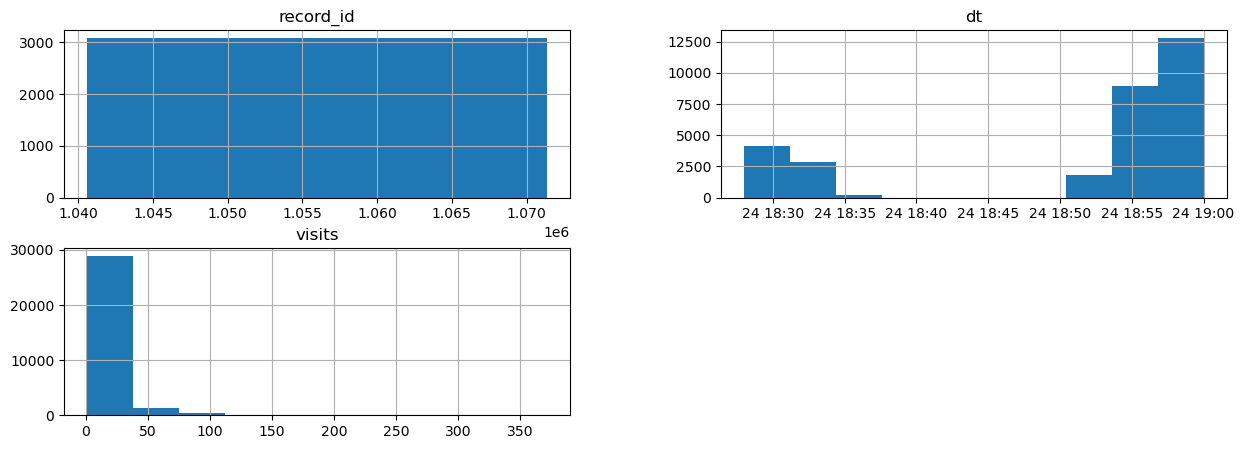

_________________________________________________________________________________________________________


In [8]:
df_analysis(data)

### Изучение уникальных значений

In [12]:
# код для просмотра уникальных значений
a = data['item_topic'].unique()
#display(a)
display(sorted(a))

['Деньги',
 'Дети',
 'Женская психология',
 'Женщины',
 'Здоровье',
 'Знаменитости',
 'Интересные факты',
 'Искусство',
 'История',
 'Красота',
 'Культура',
 'Наука',
 'Общество',
 'Отношения',
 'Подборки',
 'Полезные советы',
 'Психология',
 'Путешествия',
 'Рассказы',
 'Россия',
 'Семья',
 'Скандалы',
 'Туризм',
 'Шоу',
 'Юмор']

In [13]:
a1 = data['source_topic'].unique()
display(sorted(a1))

['Авто',
 'Деньги',
 'Дети',
 'Еда',
 'Здоровье',
 'Знаменитости',
 'Интерьеры',
 'Искусство',
 'История',
 'Кино',
 'Музыка',
 'Одежда',
 'Полезные советы',
 'Политика',
 'Психология',
 'Путешествия',
 'Ремонт',
 'Россия',
 'Сад и дача',
 'Сделай сам',
 'Семейные отношения',
 'Семья',
 'Спорт',
 'Строительство',
 'Технологии',
 'Финансы']

In [14]:
a2 = data['age_segment'].unique()
display(sorted(a2))

['18-25', '26-30', '31-35', '36-40', '41-45', '45+']

#### Вывод по data:
  
- названия заголовков корректные  
- явных дубликатов не выявлено  
- неявных дубликатов в столбцах item_topic, source_topic, age_segment нет  
- преобразование форматов данных не требуется  
- пропущенных значений нет  
- в работе данные по событиям за полчаса одного дня (24.09.2019 с 18.30 - 19.00)  
- количество визитов преимушественно до 30, выбросы в данных до числового значения 350  
- предобработка данных не требуется, таблица без изменений    

## Часть 3. Анализ данных

### Содержимое дашборда

#### Шкала времени

In [15]:
# минимальное/максимальное значения
print('Временной период получения данных:',data['dt'].min(), '-', data['dt'].max())

Временной период получения данных: 2019-09-24 18:28:00 - 2019-09-24 19:00:00


#### События по темам карточек

In [16]:
item_subject = data.groupby('item_topic').agg({'visits' : 'sum', 'record_id' : 'count'}).reset_index().rename(
    columns={'record_id':'count_event'}).sort_values(by = 'visits', ascending=False)
item_subject['fraction_visits,%'] = round(item_subject['visits'] / item_subject['visits'].sum() *100, 2)
item_subject

,item_topic,visits,count_event,"fraction_visits,%"
11,Наука,21736,1505,7.01
13,Отношения,20666,1536,6.66
6,Интересные факты,19942,1535,6.43
12,Общество,19640,1422,6.33
14,Подборки,17772,1456,5.73
19,Россия,16966,1385,5.47
15,Полезные советы,15435,1424,4.98
8,История,15389,1363,4.96
20,Семья,11897,1287,3.84
3,Женщины,11499,1230,3.71


#### События по темам источников

In [17]:
source_subject = data.groupby('source_topic').agg({'visits' : 'sum', 'record_id' : 'count'}).reset_index().rename(
    columns={'record_id':'count_event'}).sort_values(by = 'visits', ascending=False)
source_subject['fraction_visits,%'] = round(source_subject['visits'] / source_subject['visits'].sum() *100, 2)
source_subject

,source_topic,visits,count_event,"fraction_visits,%"
20,Семейные отношения,33309,1822,10.74
17,Россия,29831,1687,9.62
12,Полезные советы,27412,1578,8.84
15,Путешествия,24124,1563,7.78
5,Знаменитости,23945,1650,7.72
9,Кино,20084,1505,6.47
2,Дети,15243,1459,4.91
8,История,14628,1437,4.72
21,Семья,13896,1405,4.48
4,Здоровье,12831,1243,4.14


#### Возрастные группы

In [18]:
age_subject = data.groupby('age_segment').agg({'visits' : 'sum', 'record_id' : 'count'}).reset_index().rename(
    columns={'record_id':'count_event'}).sort_values(by = 'visits', ascending=False)
age_subject['fraction_visits,%'] = round(age_subject['visits'] / age_subject['visits'].sum() *100, 2)
age_subject

,age_segment,visits,count_event,"fraction_visits,%"
0,18-25,131010,7056,42.23
1,26-30,60311,5875,19.44
2,31-35,53763,5552,17.33
3,36-40,38166,5105,12.30
4,41-45,16263,3903,5.24
5,45+,10694,3254,3.45


### Экспорт данных в csv-файл

In [19]:
# преобразование в csv
data.to_csv('dash_visits.csv', index=False)

In [20]:
# проверка
dash_visits = pd.read_csv('dash_visits.csv')
dash_visits.head(3)

,record_id,item_topic,source_topic,age_segment,dt,visits
0,1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1,1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1
2,1040599,Деньги,Авто,18-25,2019-09-24 18:54:00,4


## Часть 4. Дашборд

https://public.tableau.com/app/profile/alla.k./viz/AllaK_/Dashboard1

## Часть 5. Презентация

https://github.com/Alla-Kuhtenko/Portfolio_YP/blob/main/Automation-analytics-Zen/Automation-analytics-Zen.pdf

## Вывод и рекомендации.  

In [22]:
print(' ')
print('Количество взаимодействий пользователей с карточками в системе:', source_subject['visits'].sum())
print(' ')
print('Количество карточек, генерирующих источники с разными темами:', item_subject['item_topic'].count())
print(' ')
print('Количество источников, генерирующих карточки с разными темами:', source_subject['source_topic'].count())

 
Количество взаимодействий пользователей с карточками в системе: 310207
 
Количество карточек, генерирующих источники с разными темами: 25
 
Количество источников, генерирующих карточки с разными темами: 26


В проекте представлена обзорная сводная информация о взаимодействии пользователей с карточками Яндекс.Дзен.  
Так как полученная информация требует детализированного изучения каждой группы пользователей и их интересов, рекомендовано работать с визуализированной информацией.  
Для этого создан дашборд, который предоставляет возможность фильтрации данных по темам карточек, темам источников, возрастным группам, дате/времени.  
Информацией о проделанной работе можно ознакомиться в презентации.